In [1]:
# import os
# os.makedirs("datasets", exist_ok=True)
# !wget https://dp-public.oss-cn-beijing.aliyuncs.com/community/hERG.csv -O datasets/hERG.csv

### watch data

------------ Original data ------------
                                                 SMILES  pIC50
0     Cc1ccc(CN2[C@@H]3CC[C@H]2C[C@@H](C3)Oc4cccc(c4...   9.85
1     COc1nc2ccc(Br)cc2cc1[C@@H](c3ccccc3)[C@@](O)(C...   9.70
2     NC(=O)c1cccc(O[C@@H]2C[C@H]3CC[C@@H](C2)N3CCCc...   9.60
3                          CCCCCCCc1cccc([n+]1C)CCCCCCC   9.60
4     Cc1ccc(CN2[C@@H]3CC[C@H]2C[C@@H](C3)Oc4cccc(c4...   9.59
...                                                 ...    ...
9199  O=C1[C@H]2N(c3ccc(OCC=CCCNCC(=O)Nc4c(Cl)cc(cc4...   4.89
9200  O=C1[C@H]2N(c3ccc(OCCCCCNCC(=O)Nc4c(Cl)cc(cc4C...   4.89
9201  O=C1[C@H]2N(c3ccc(OCC=CCCCNCC(=O)Nc4c(Cl)cc(cc...   4.89
9202  O=C1[C@H]2N(c3ccc(OCCCCCCNCC(=O)Nc4c(Cl)cc(cc4...   4.49
9203  O=C1N=C/C(=C2\N(c3c(cc(Cl)c(Cl)c3)N\2)Cc4cc(Cl...   5.30

[9204 rows x 2 columns]


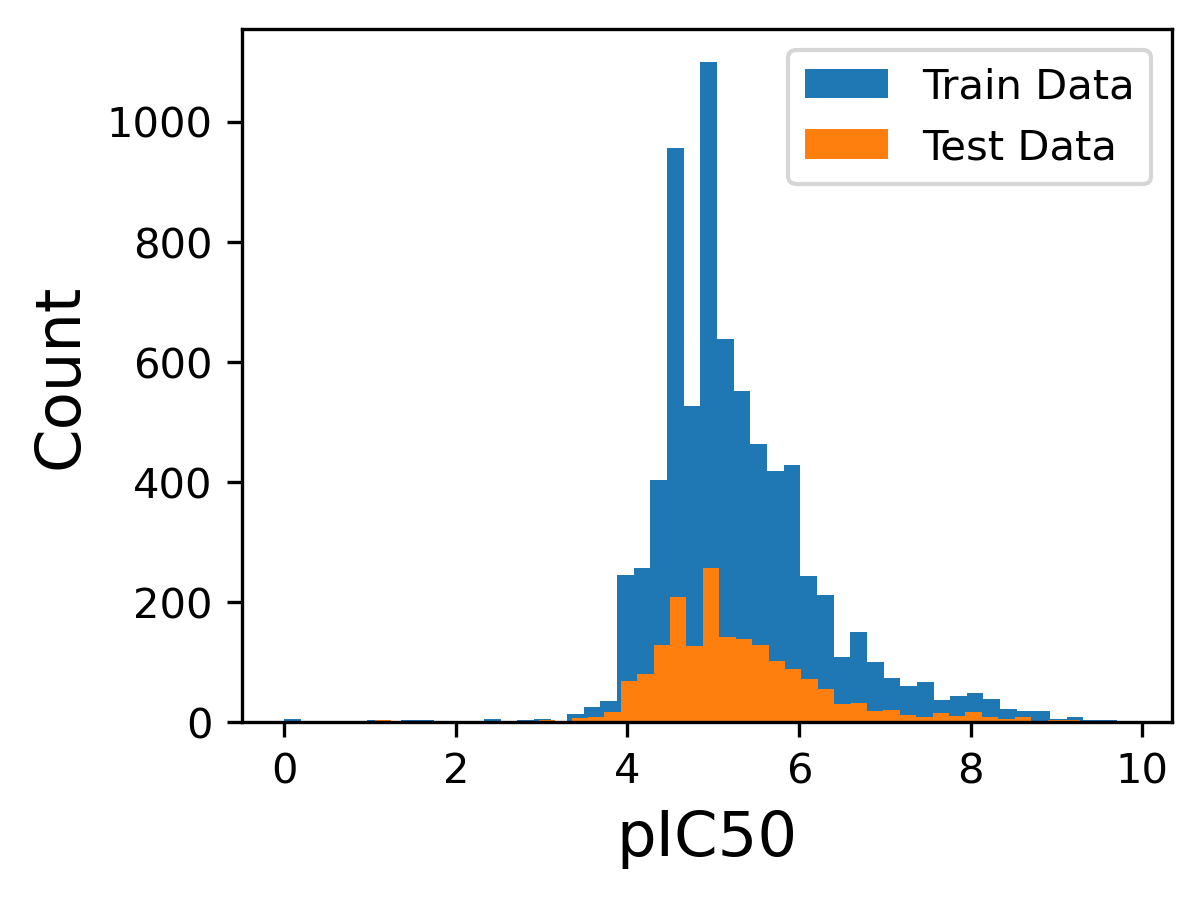

In [7]:
import pandas as pd
import numpy as np

data = pd.read_csv("./datasets/hERG.csv")
print("------------ Original data ------------")
print(data)
data.columns = ["SMILES", "TARGET"]

# 将数据集的80%设置为训练数据集，20%设置为测试数据集
train_fraction = 0.8
train_data = data.sample(frac=train_fraction, random_state=1)
train_data.to_csv("./datasets/hERG_train.csv", index=False)
test_data = data.drop(train_data.index)
test_data.to_csv("./datasets/hERG_test.csv", index=False)

# 设定训练/测试目标
train_y = np.array(train_data["TARGET"].values.tolist())
test_y = np.array(test_data["TARGET"].values.tolist())

# 创建一个用来存后面结果的results
results = {}

# 可视化结果
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(4,3), dpi=300)
font = {
        'color':  'black',
        'weight': 'normal',
        'size': 15}
plt.hist(train_data["TARGET"], bins=50, label="Train Data")
plt.hist(test_data["TARGET"], bins=50, label="Test Data")
plt.ylabel("Count", fontdict=font)
plt.xlabel("pIC50", fontdict=font)
plt.legend()
plt.show()

## 1D QASR

In [5]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define a function to calculate 1D-QSAR descriptors from SMILES strings
def calculate_1dqsar_repr(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return [
        Descriptors.MolWt(mol),  # Molecular weight
        Descriptors.MolLogP(mol),  # LogP value
        Descriptors.NumHDonors(mol),  # Number of H-bond donors
        Descriptors.NumHAcceptors(mol),  # Number of H-bond acceptors
        Descriptors.TPSA(mol),  # Topological polar surface area
        Descriptors.NumRotatableBonds(mol),  # Number of rotatable bonds
        Descriptors.NumAromaticRings(mol),  # Number of aromatic rings
        Descriptors.NumAliphaticRings(mol),  # Number of aliphatic rings
        Descriptors.NumSaturatedRings(mol),  # Number of saturated rings
        Descriptors.NumHeteroatoms(mol),  # Number of heteroatoms
        Descriptors.NumValenceElectrons(mol),  # Number of valence electrons
        Descriptors.NumRadicalElectrons(mol),  # Number of radical electrons
        Descriptors.qed(mol)  # Quantitative estimate of drug-likeness (QED)
    ]

# Apply the descriptor function to train and test data
train_data["1dqsar_mr"] = train_data["SMILES"].apply(calculate_1dqsar_repr)
test_data["1dqsar_mr"] = test_data["SMILES"].apply(calculate_1dqsar_repr)

# Convert feature and target columns to NumPy arrays
train_x = np.array(train_data["1dqsar_mr"].values.tolist())
train_y = np.array(train_data["TARGET"].values.tolist())
test_x = np.array(test_data["1dqsar_mr"].values.tolist())
test_y = np.array(test_data["TARGET"].values.tolist())

# Apply Min-Max normalization to the features
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)  # Normalize training data
test_x = scaler.transform(test_x)  # Apply the same normalization to test data

# Define a list of regression models
regressors = [
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge(random_state=42)),
    ("Lasso Regression", Lasso(random_state=42)),
    ("ElasticNet Regression", ElasticNet(random_state=42)),
    ("Support Vector", SVR()),
    ("K-Nearest Neighbors", KNeighborsRegressor()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("Multi-layer Perceptron", MLPRegressor(
        hidden_layer_sizes=(128, 64, 32), learning_rate_init=0.0001,
        activation='relu', solver='adam', max_iter=10000, random_state=42))
]

# Create a directory to save prediction results and plots
output_folder = "model_predictions_normalized"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Train each model, save predictions, and calculate MSE
results = {}
for name, regressor in regressors:
    regressor.fit(train_x, train_y)  # Train the model
    pred_test_y = regressor.predict(test_x)  # Make predictions on the test set

    # Save true and predicted values to a CSV file
    model_results = pd.DataFrame({"True_Values": test_y, "Predicted_Values": pred_test_y})
    csv_path = os.path.join(output_folder, f"{name}_predictions.csv")
    model_results.to_csv(csv_path, index=False)

    # Calculate and print the Mean Squared Error (MSE)
    mse = mean_squared_error(test_y, pred_test_y)
    results[name] = {"MSE": mse}
    print(f"[1D-QSAR][{name}] MSE: {mse:.4f}")

# Generate scatter plots for each model's predictions
for name, regressor in regressors:
    csv_path = os.path.join(output_folder, f"{name}_predictions.csv")
    data = pd.read_csv(csv_path)

    # Create the scatter plot
    plt.figure(figsize=(4, 4))
    plt.scatter(data["True_Values"], data["Predicted_Values"], alpha=0.7, label="Predictions")
    plt.plot(
        [0, max(data["True_Values"].max(), data["Predicted_Values"].max())],
        [0, max(data["True_Values"].max(), data["Predicted_Values"].max())],
        color="red", linestyle="--", label="Perfect Prediction (y=x)"
    )

    # Set plot labels, title, and grid
    plt.title(f"{name}", fontsize=12)
    plt.xlabel("True Values", fontsize=12)
    plt.ylabel("Predicted Values", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Ensure plot content fits within the saved image
    plt.xlim(0, max(data["True_Values"].max(), data["Predicted_Values"].max()))
    plt.ylim(0, max(data["True_Values"].max(), data["Predicted_Values"].max()))
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"{name}_scatter_plot.png"), dpi=300)
    plt.close()

print("Normalized predictions and scatter plots have been saved.")

[1D-QSAR][Linear Regression] MSE: 0.8857
[1D-QSAR][Ridge Regression] MSE: 0.8852
[1D-QSAR][Lasso Regression] MSE: 1.0109
[1D-QSAR][ElasticNet Regression] MSE: 1.0109
[1D-QSAR][Support Vector] MSE: 0.8099
[1D-QSAR][K-Nearest Neighbors] MSE: 0.6941
[1D-QSAR][Decision Tree] MSE: 1.0583
[1D-QSAR][Random Forest] MSE: 0.6064
[1D-QSAR][Gradient Boosting] MSE: 0.7609
[1D-QSAR][XGBoost] MSE: 0.6249
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1232
[LightGBM] [Info] Number of data points in the train set: 7363, number of used features: 12
[LightGBM] [Info] Start training from score 5.279727
[1D-QSAR][LightGBM] MSE: 0.6440
[1D-QSAR][Multi-layer Perceptron] MSE: 0.7217
Normalized predictions and scatter plots have been saved.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import os

# 定义一个函数来计算 SMILES 字符串的 1D-QSAR 描述符
def calculate_1dqsar_repr(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumAromaticRings(mol),
        Descriptors.NumAliphaticRings(mol),
        Descriptors.NumSaturatedRings(mol),
        Descriptors.NumHeteroatoms(mol),
        Descriptors.NumValenceElectrons(mol),
        Descriptors.NumRadicalElectrons(mol),
        Descriptors.qed(mol)
    ]

# 假设 data 已经被加载
# data = pd.read_csv('your_dataset.csv')

# 将数据分为训练集、验证集和测试集
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)  # 先分出20%作为测试集
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # 将剩余数据一分为二

# 应用描述符函数到训练集、验证集和测试集
train_data["1dqsar_mr"] = train_data["SMILES"].apply(calculate_1dqsar_repr)
validation_data["1dqsar_mr"] = validation_data["SMILES"].apply(calculate_1dqsar_repr)
test_data["1dqsar_mr"] = test_data["SMILES"].apply(calculate_1dqsar_repr)

# 转换特征和目标列为 NumPy 数组
train_x = np.array(train_data["1dqsar_mr"].values.tolist())
train_y = np.array(train_data["TARGET"].values.tolist())
validation_x = np.array(validation_data["1dqsar_mr"].values.tolist())
validation_y = np.array(validation_data["TARGET"].values.tolist())
test_x = np.array(test_data["1dqsar_mr"].values.tolist())
test_y = np.array(test_data["TARGET"].values.tolist())

# 应用 Min-Max 归一化到特征
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)  # 训练归一化模型并转换训练数据
validation_x = scaler.transform(validation_x)  # 应用同样的归一化到验证数据
test_x = scaler.transform(test_x)  # 应用同样的归一化到测试数据

# 定义模型列表
regressors = [
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge(random_state=42)),
    ("Lasso Regression", Lasso(random_state=42)),
    ("ElasticNet Regression", ElasticNet(random_state=42)),
    ("Support Vector", SVR()),
    ("K-Nearest Neighbors", KNeighborsRegressor()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("Multi-layer Perceptron", MLPRegressor(hidden_layer_sizes=(128, 64, 32), learning_rate_init=0.0001, activation='relu', solver='adam', max_iter=10000, random_state=42))
]

# 用验证集调整模型参数并评估
best_mse = float('inf')
best_model = None
for name, regressor in regressors:
    regressor.fit(train_x, train_y)  # 训练模型
    pred_validation_y = regressor.predict(validation_x)  # 在验证集上做预测
    mse = mean_squared_error(validation_y, pred_validation_y)  # 计算 MSE
    print(f"{name} Validation MSE: {mse:.4f}")
    if mse < best_mse:
        best_mse = mse
        best_model = (name, regressor)

# 使用最佳模型在测试集上做最终评估
pred_test_y = best_model[1].predict(test_x)
final_mse = mean_squared_error(test_y, pred_test_y)
print(f"Best Model: {best_model[0]} Test MSE: {final_mse:.4f}")


Linear Regression Validation MSE: 0.8522
Ridge Regression Validation MSE: 0.8505
Lasso Regression Validation MSE: 0.9620
ElasticNet Regression Validation MSE: 0.9620
Support Vector Validation MSE: 0.8336
K-Nearest Neighbors Validation MSE: 0.6402
Decision Tree Validation MSE: 1.0055
Random Forest Validation MSE: 0.5844
Gradient Boosting Validation MSE: 0.7427
XGBoost Validation MSE: 0.6080
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 7363, number of used features: 12
[LightGBM] [Info] Start training from score 5.271810
LightGBM Validation MSE: 0.6262
Multi-layer Perceptron Validation MSE: 0.7095
Best Model: Random Forest Test MSE: 0.6303


In [25]:
# Prepare the MSE data for saving to CSV and sort by MSE in ascending order
mse_data = [{"Model": name, "MSE": result["MSE"]} for name, result in results.items()]

# Convert the data into a DataFrame
mse_df = pd.DataFrame(mse_data)

# Sort the DataFrame by MSE in ascending order
mse_df = mse_df.sort_values(by="MSE", ascending=True)

# Save the sorted DataFrame to a CSV file
mse_csv_path = "1d_qasr_mse_sorted.csv"
mse_df.to_csv(mse_csv_path, index=False)

# Confirm the file was saved successfully
print(f"Sorted MSE results have been saved to {mse_csv_path}")

Sorted MSE results have been saved to 1d_qasr_mse_sorted.csv


In [31]:
len(train_data['1dqsar_mr'][1])

13

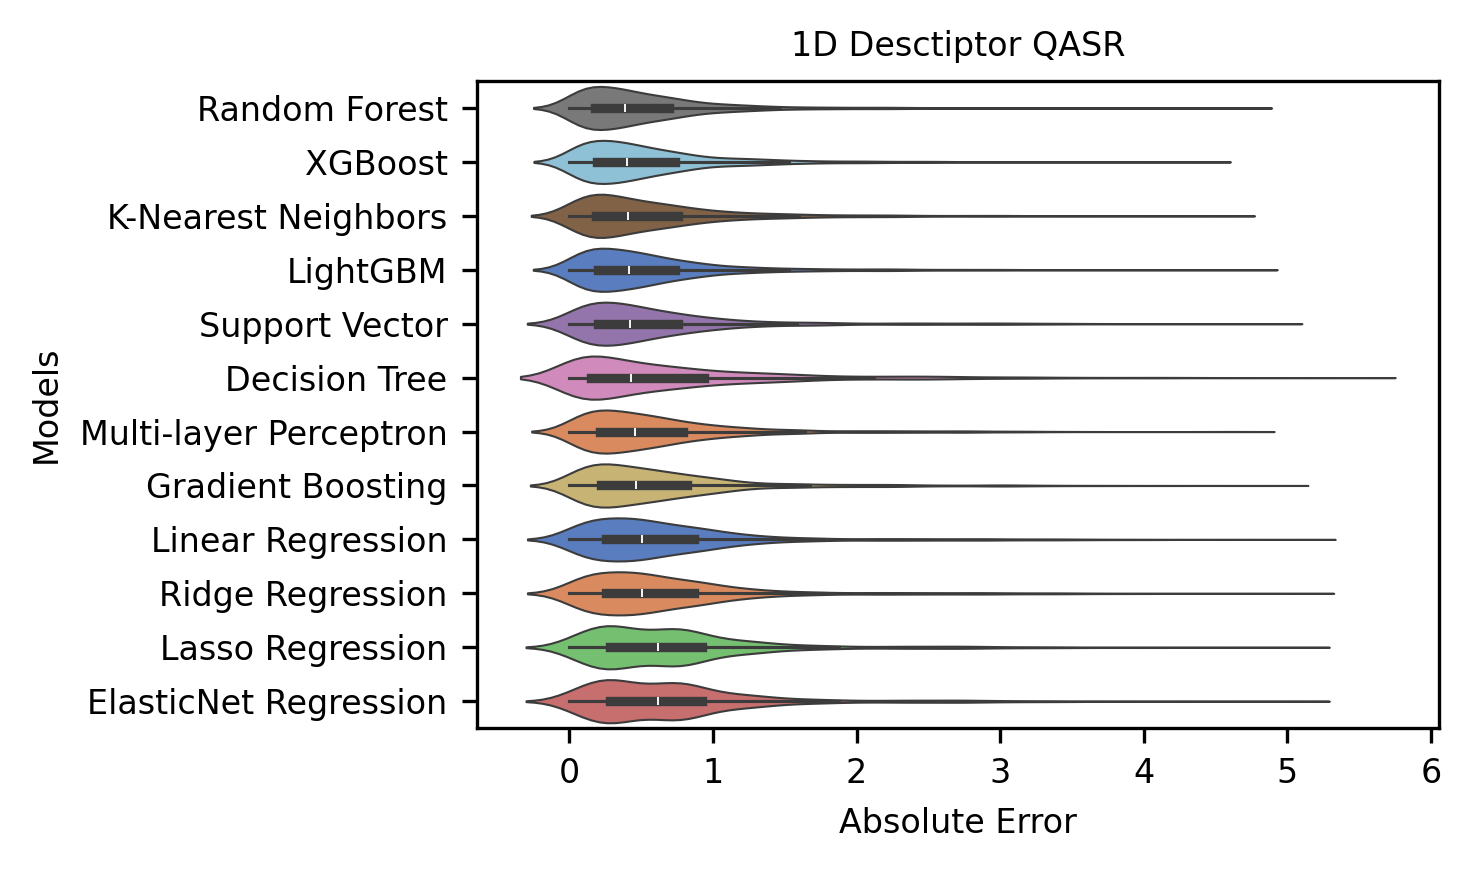

In [23]:
# Prepare residuals data for the violin plot
residuals_data = []

for name, regressor in regressors:
    # Load the predictions for each model
    csv_path = os.path.join(output_folder, f"{name}_predictions.csv")
    data = pd.read_csv(csv_path)

    # Calculate residuals (absolute errors)
    residuals = abs(data["True_Values"] - data["Predicted_Values"])
    model_residuals = pd.DataFrame({"Model": name, "Error": residuals})
    residuals_data.append(model_residuals)

# Concatenate all residuals into a single DataFrame
residuals_df = pd.concat(residuals_data, ignore_index=True)

# Determine model order by median error
model_order = residuals_df.groupby("Model")["Error"].median().sort_values(ascending=True).index


# Adjusted code to remove warnings and fix font size for axis labels

# Generate violin plot with academic aesthetics
plt.figure(figsize=(5, 3), dpi=300)

# Use seaborn to create a violin plot, with updated parameters to remove warnings
sns.violinplot(
    x="Error", 
    y="Model", 
    data=residuals_df, 
    order=model_order, 
    hue="Model", 
    dodge=False, 
    legend=False, 
    density_norm="width",  # Replace deprecated "scale"
    palette="muted",
    linewidth=0.5  # Set thinner line width
)

# Set labels and adjust font sizes
font = {'family': 'serif',
        'color': 'black',
        'weight': 'normal',
        'size': 8}  # Reduced size for axis labels
plt.title("1D Desctiptor QASR", fontsize=8)
plt.xlabel("Absolute Error",fontsize=8)
plt.ylabel("Models",fontsize=8)
plt.xticks(fontsize=8)  # Smaller tick font size
plt.yticks(fontsize=8)  # Smaller tick font size

# Apply a tight layout for academic aesthetics
plt.tight_layout()
plt.savefig("1d_qasr_violin_plot.png")
# Show the plot
plt.show()

## 2D QASR

[2D-QSAR][Linear Regression] MSE: 0.6616
[2D-QSAR][Ridge Regression] MSE: 0.6602
[2D-QSAR][Lasso Regression] MSE: 1.0109
[2D-QSAR][ElasticNet Regression] MSE: 1.0109
[2D-QSAR][Support Vector] MSE: 0.4445
[2D-QSAR][K-Nearest Neighbors] MSE: 0.4691
[2D-QSAR][Decision Tree] MSE: 0.9071
[2D-QSAR][Random Forest] MSE: 0.4471
[2D-QSAR][Gradient Boosting] MSE: 0.6157
[2D-QSAR][XGBoost] MSE: 0.4375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 7363, number of used features: 1024
[LightGBM] [Info] Start training from score 5.279727
[2D-QSAR][LightGBM] MSE: 0.4631
[2D-QSAR][Multi-layer Perceptron] MSE: 0.6006


/tmp/ipykernel_3334925/1259239783.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


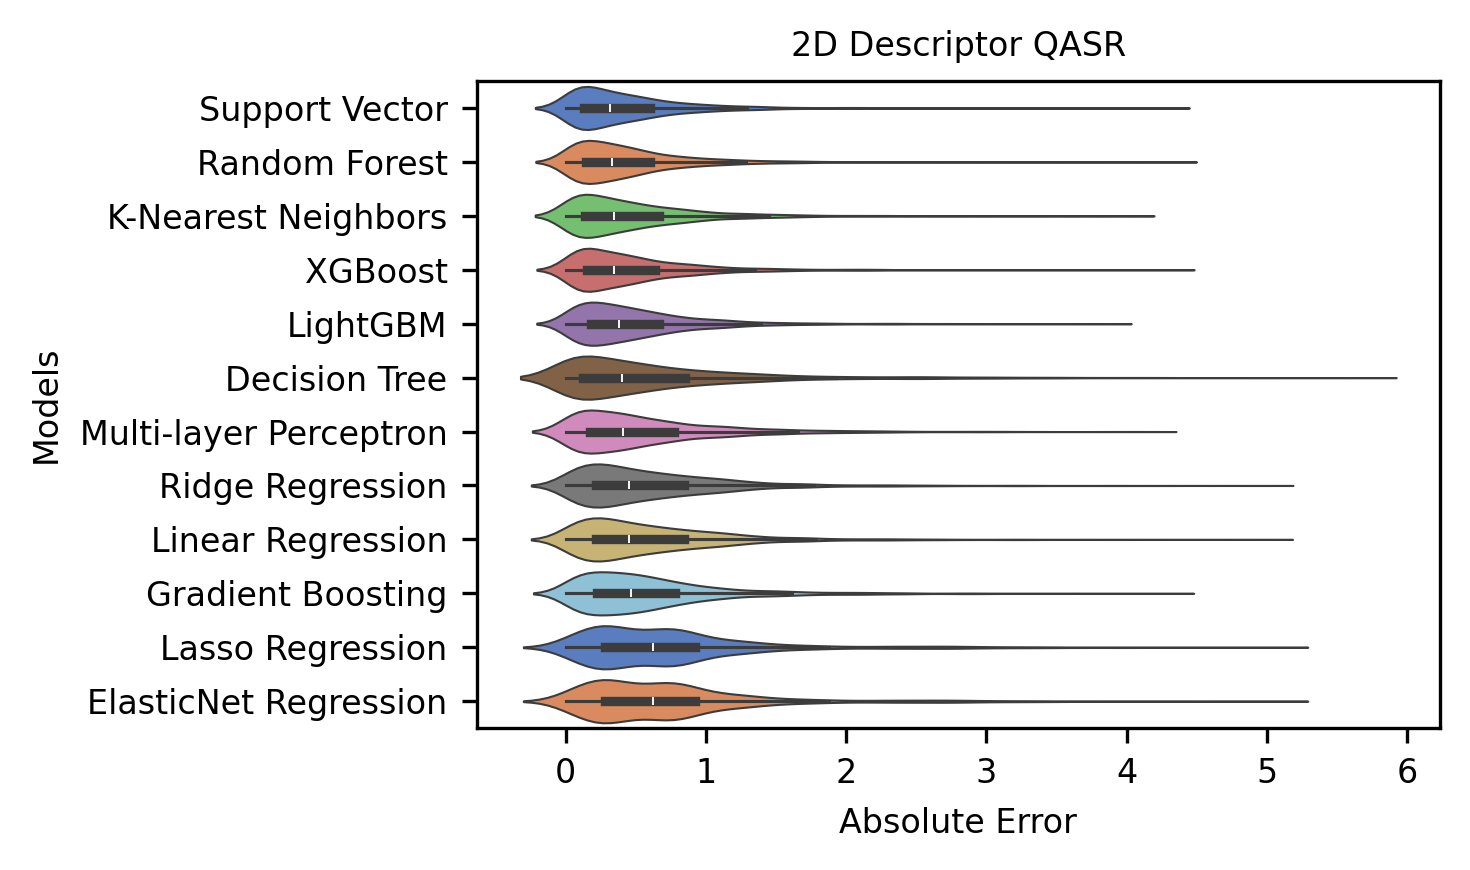

Sorted MSE results have been saved to 2d_qasr_mse_sorted.csv


In [36]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# Step 1: Calculate 2D-QSAR Descriptors
def calculate_2dqsar_repr(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Return None for invalid SMILES
    generator = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=1024)
    fp = generator.GetFingerprint(mol)
    return np.array(fp)

# Apply descriptor calculation to training and test datasets
train_data["2dqsar_mr"] = train_data["SMILES"].apply(calculate_2dqsar_repr)
test_data["2dqsar_mr"] = test_data["SMILES"].apply(calculate_2dqsar_repr)

# Remove invalid rows
train_data = train_data.dropna(subset=["2dqsar_mr"])
test_data = test_data.dropna(subset=["2dqsar_mr"])

# Convert descriptors and targets to NumPy arrays
train_x = np.array(train_data["2dqsar_mr"].tolist())
train_y = np.array(train_data["TARGET"].tolist())
test_x = np.array(test_data["2dqsar_mr"].tolist())
test_y = np.array(test_data["TARGET"].tolist())

# Step 2: Define regression models
regressors = [
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge(random_state=42)),
    ("Lasso Regression", Lasso(random_state=42)),
    ("ElasticNet Regression", ElasticNet(random_state=42)),
    ("Support Vector", SVR()),
    ("K-Nearest Neighbors", KNeighborsRegressor()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("Multi-layer Perceptron", MLPRegressor(
        hidden_layer_sizes=(128, 64, 32), learning_rate_init=0.0001,
        activation='relu', solver='adam', max_iter=10000, random_state=42))
]

# Step 3: Train models and save predictions
output_folder_2d = "model_predictions_2d"
if not os.path.exists(output_folder_2d):
    os.makedirs(output_folder_2d)

results_2d = {}
for name, regressor in regressors:
    regressor.fit(train_x, train_y)
    pred_test_y = regressor.predict(test_x)

    # Save true and predicted values to CSV
    model_results = pd.DataFrame({"True_Values": test_y, "Predicted_Values": pred_test_y})
    csv_path = os.path.join(output_folder_2d, f"{name}_predictions.csv")
    model_results.to_csv(csv_path, index=False)

    # Calculate MSE
    mse = mean_squared_error(test_y, pred_test_y)
    results_2d[name] = {"MSE": mse, "error": abs(test_y - pred_test_y)}
    print(f"[2D-QSAR][{name}] MSE: {mse:.4f}")

# Step 4: Generate scatter plots
for name, regressor in regressors:
    csv_path = os.path.join(output_folder_2d, f"{name}_predictions.csv")
    data = pd.read_csv(csv_path)

    # Scatter plot
    plt.figure(figsize=(4, 4), dpi=300)
    plt.scatter(data["True_Values"], data["Predicted_Values"], alpha=0.7, label="Predictions")
    plt.plot(
        [0, max(data["True_Values"].max(), data["Predicted_Values"].max())],
        [0, max(data["True_Values"].max(), data["Predicted_Values"].max())],
        color="red", linestyle="--", label="Perfect Prediction (y=x)"
    )
    plt.title(f"{name}", fontsize=12)
    plt.xlabel("True Values", fontsize=10)
    plt.ylabel("Predicted Values", fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(fontsize=8)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder_2d, f"{name}_scatter_plot.png"), dpi=300)
    plt.close()

# Step 5: Generate violin plot
residuals_data = []
for name, result in results_2d.items():
    model_residuals = pd.DataFrame({"Model": name, "Error": result["error"]})
    residuals_data.append(model_residuals)

residuals_df = pd.concat(residuals_data, ignore_index=True)
model_order = residuals_df.groupby("Model")["Error"].median().sort_values(ascending=True).index

plt.figure(figsize=(5, 3), dpi=300)
sns.violinplot(
    x="Error", y="Model", data=residuals_df, order=model_order,
    palette="muted", density_norm="width", linewidth=0.5
)
plt.title("2D Descriptor QASR", fontsize=8)
plt.xlabel("Absolute Error", fontsize=8)
plt.ylabel("Models", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig("2d_qasr_violin_plot.png")
plt.show()

# Step 6: Save MSE results to CSV
mse_data = [{"Model": name, "MSE": result["MSE"]} for name, result in results_2d.items()]
mse_df = pd.DataFrame(mse_data).sort_values(by="MSE", ascending=True)
mse_csv_path = "2d_qasr_mse_sorted.csv"
mse_df.to_csv(mse_csv_path, index=False)
print(f"Sorted MSE results have been saved to {mse_csv_path}")

## 3D-QASR

------------ Original data ------------
                                                 SMILES  pIC50
0     Cc1ccc(CN2[C@@H]3CC[C@H]2C[C@@H](C3)Oc4cccc(c4...   9.85
1     COc1nc2ccc(Br)cc2cc1[C@@H](c3ccccc3)[C@@](O)(C...   9.70
2     NC(=O)c1cccc(O[C@@H]2C[C@H]3CC[C@@H](C2)N3CCCc...   9.60
3                          CCCCCCCc1cccc([n+]1C)CCCCCCC   9.60
4     Cc1ccc(CN2[C@@H]3CC[C@H]2C[C@@H](C3)Oc4cccc(c4...   9.59
...                                                 ...    ...
9199  O=C1[C@H]2N(c3ccc(OCC=CCCNCC(=O)Nc4c(Cl)cc(cc4...   4.89
9200  O=C1[C@H]2N(c3ccc(OCCCCCNCC(=O)Nc4c(Cl)cc(cc4C...   4.89
9201  O=C1[C@H]2N(c3ccc(OCC=CCCCNCC(=O)Nc4c(Cl)cc(cc...   4.89
9202  O=C1[C@H]2N(c3ccc(OCCCCCCNCC(=O)Nc4c(Cl)cc(cc4...   4.49
9203  O=C1N=C/C(=C2\N(c3c(cc(Cl)c(Cl)c3)N\2)Cc4cc(Cl...   5.30

[9204 rows x 2 columns]


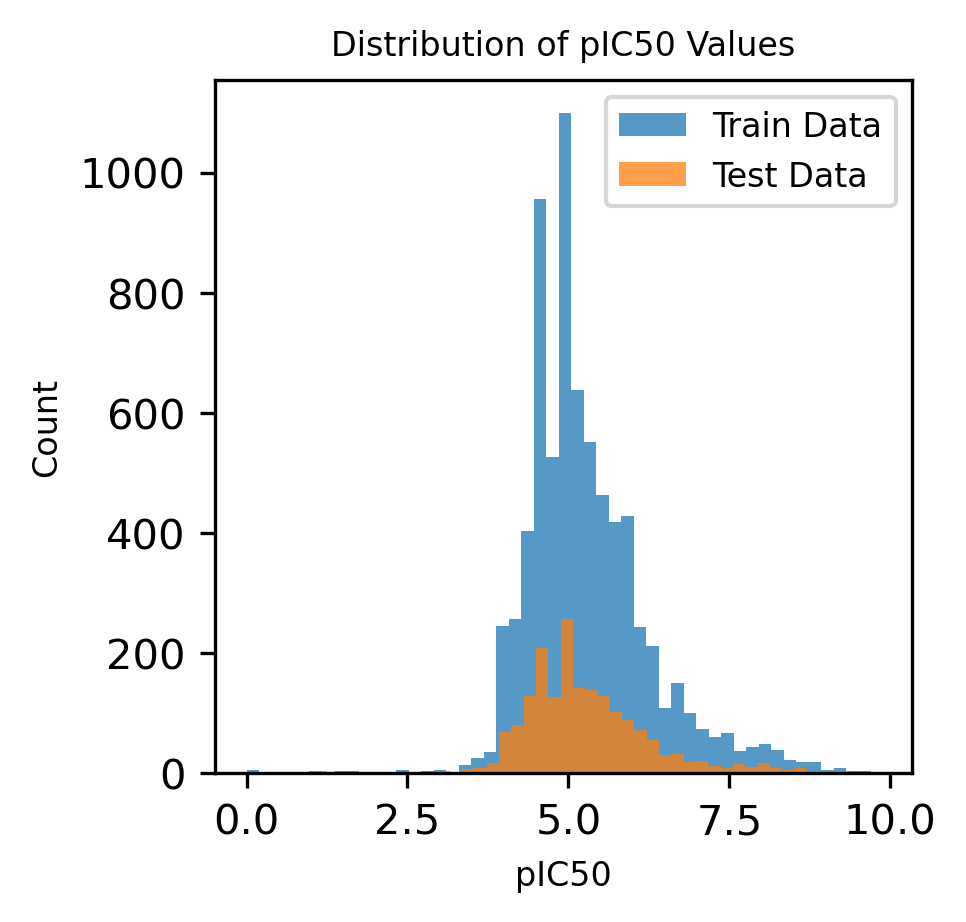

In [83]:
import pandas as pd
import numpy as np

# Load data from a CSV file
data = pd.read_csv("./datasets/hERG.csv")
print("------------ Original data ------------")
print(data)

# Rename columns for clarity
data.columns = ["SMILES", "TARGET"]

# Set 80% of the dataset as the training dataset and 20% as the testing dataset
train_fraction = 0.8
train_data = data.sample(frac=train_fraction, random_state=1)
train_data.to_csv("./datasets/hERG_train.csv", index=False)
test_data = data.drop(train_data.index)
test_data.to_csv("./datasets/hERG_test.csv", index=False)

# Set the training/testing targets
train_y = np.array(train_data["TARGET"].values.tolist())
test_y = np.array(test_data["TARGET"].values.tolist())

# Create a dictionary to store results
results = {}

# Visualize the results
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(3, 3), dpi=300)
font = {
        'color':  'black',
        'weight': 'normal',
        'size': 8}  # Set font size to 8 for all text elements
plt.hist(train_data["TARGET"], bins=50, label="Train Data", alpha=0.75)
plt.hist(test_data["TARGET"], bins=50, label="Test Data", alpha=0.75)
plt.ylabel("Count", fontdict=font)
plt.xlabel("pIC50", fontdict=font)
plt.title("Distribution of pIC50 Values", fontdict=font)  # Title with adjusted font size
plt.legend(prop={'size': 8})  # Adjust legend font size
plt.show()

In [84]:
from rdkit.Chem import rdPartialCharges

def calculate_3dqsar_repr(SMILES, max_atoms=100, three_d=False):
    mol = Chem.MolFromSmiles(SMILES)  # Create a molecule object from SMILES representation
    mol = Chem.AddHs(mol)  # Add hydrogen atoms
    if three_d:
        AllChem.EmbedMolecule(mol, AllChem.ETKDG())  # Compute 3D coordinates
    else:
        AllChem.Compute2DCoords(mol)  # Compute 2D coordinates
    natoms = mol.GetNumAtoms()  # Get the number of atoms
    rdPartialCharges.ComputeGasteigerCharges(mol)  # Calculate Gasteiger charges for the molecule
    charges = np.array([float(atom.GetProp("_GasteigerCharge")) for atom in mol.GetAtoms()])  # Retrieve charge values
    coords = mol.GetConformer().GetPositions()  # Get atomic coordinates
    coulomb_matrix = np.zeros((max_atoms, max_atoms))  # Initialize Coulomb matrix
    n = min(max_atoms, natoms)
    for i in range(n):  # Iterate over atoms
        for j in range(i, n):
            if i == j:
                coulomb_matrix[i, j] = 0.5 * charges[i] ** 2
            if i != j:
                delta = np.linalg.norm(coords[i] - coords[j])  # Calculate the distance between atoms
                if delta != 0:
                    coulomb_matrix[i, j] = charges[i] * charges[j] / delta  # Compute elements of the Coulomb matrix
                    coulomb_matrix[j, i] = coulomb_matrix[i, j]
    coulomb_matrix = np.where(np.isinf(coulomb_matrix), 0, coulomb_matrix)  # Handle infinite values
    coulomb_matrix = np.where(np.isnan(coulomb_matrix), 0, coulomb_matrix)  # Handle NaN values
    return coulomb_matrix.reshape(max_atoms*max_atoms).tolist()  # Convert the Coulomb matrix to a list and return

train_data["3dqsar_mr"] = train_data["SMILES"].apply(calculate_3dqsar_repr)
test_data["3dqsar_mr"] = test_data["SMILES"].apply(calculate_3dqsar_repr)

from sklearn.decomposition import PCA

# Define a PCA object, setting n_components to 512, which means reducing dimensions to 512
pca = PCA(n_components=512)

# Fit and transform the training data
train_data_pca = pca.fit_transform(np.array(train_data["3dqsar_mr"].tolist()))

# Transform the test data
test_data_pca = pca.transform(np.array(test_data["3dqsar_mr"].tolist()))

# Store the reduced dimension data as a new column
train_data["3dqsar_mr_pca"] = train_data_pca.tolist()
test_data["3dqsar_mr_pca"] = test_data_pca.tolist()

In [85]:
len(train_data["3dqsar_mr_pca"][1])

512

In [ ]:
from xgboost import XGBRegressor

In [86]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# 将训练和测试数据转换为NumPy数组
train_x = np.array(train_data["3dqsar_mr_pca"].values.tolist())
train_y = np.array(train_data["TARGET"].values.tolist())
test_x = np.array(test_data["3dqsar_mr_pca"].values.tolist())
test_y = np.array(test_data["TARGET"].values.tolist())

# 定义要使用的回归器列表
regressors = [
    ("Linear Regression", LinearRegression()), # 线性回归模型
    ("Ridge Regression", Ridge(random_state=42)), # 岭回归模型
    ("Lasso Regression", Lasso(random_state=42)), # Lasso回归模型
    ("ElasticNet Regression", ElasticNet(random_state=42)), # ElasticNet回归模型
    ("Support Vector", SVR()),  # 支持向量回归模型
    ("K-Nearest Neighbors", KNeighborsRegressor()),  # K-最近邻回归模型
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),  # 决策树回归模型
    ("Random Forest", RandomForestRegressor(random_state=42)), # 随机森林回归模型
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42)), # 梯度提升回归模型
    ("XGBoost", XGBRegressor(random_state=42)), # XGBoost回归模型
    ("LightGBM", LGBMRegressor(random_state=42)), # LightGBM回归模型
    ("Multi-layer Perceptron", MLPRegressor( # 多层感知器（神经网络）回归模型
        hidden_layer_sizes=(128,64,32),
        learning_rate_init=0.0001,
        activation='relu', solver='adam', 
        max_iter=10000, random_state=42)),
]

# 对每个回归器进行训练和预测，并计算各项性能指标
for name, regressor in regressors:
    # 训练回归器
    regressor.fit(train_x, train_y)
    # 预测训练数据和测试数据
    pred_train_y = regressor.predict(train_x)
    pred_test_y = regressor.predict(test_x)
    # 将预测结果添加到训练数据和测试数据中
    train_data[f"3D-QSAR-{name}_pred"] = pred_train_y
    test_data[f"3D-QSAR-{name}_pred"] = pred_test_y
    # 计算测试数据的性能指标
    mse = mean_squared_error(test_y, pred_test_y)
    se = abs(test_y - pred_test_y)
    results[f"3D-QSAR-{name}"] = {"MSE": mse, "error": se}
    print(f"[3D-QSAR][{name}]\tMSE:{mse:.4f}")

[3D-QSAR][Linear Regression]	MSE:40198743239555768763023360.0000
[3D-QSAR][Ridge Regression]	MSE:5601950952227601156931584.0000
[3D-QSAR][Lasso Regression]	MSE:805.7537
[3D-QSAR][ElasticNet Regression]	MSE:2390.2504


/home/jhe378/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.09736e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


[3D-QSAR][Support Vector]	MSE:1.0427
[3D-QSAR][K-Nearest Neighbors]	MSE:1.1162
[3D-QSAR][Decision Tree]	MSE:1.6992
[3D-QSAR][Random Forest]	MSE:0.7818
[3D-QSAR][Gradient Boosting]	MSE:0.8794
[3D-QSAR][XGBoost]	MSE:0.8050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130557
[LightGBM] [Info] Number of data points in the train set: 7363, number of used features: 512
[LightGBM] [Info] Start training from score 5.279727
[3D-QSAR][LightGBM]	MSE:0.7487
[3D-QSAR][Multi-layer Perceptron]	MSE:6033541020580354981888.0000


/tmp/ipykernel_3334925/3741434329.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


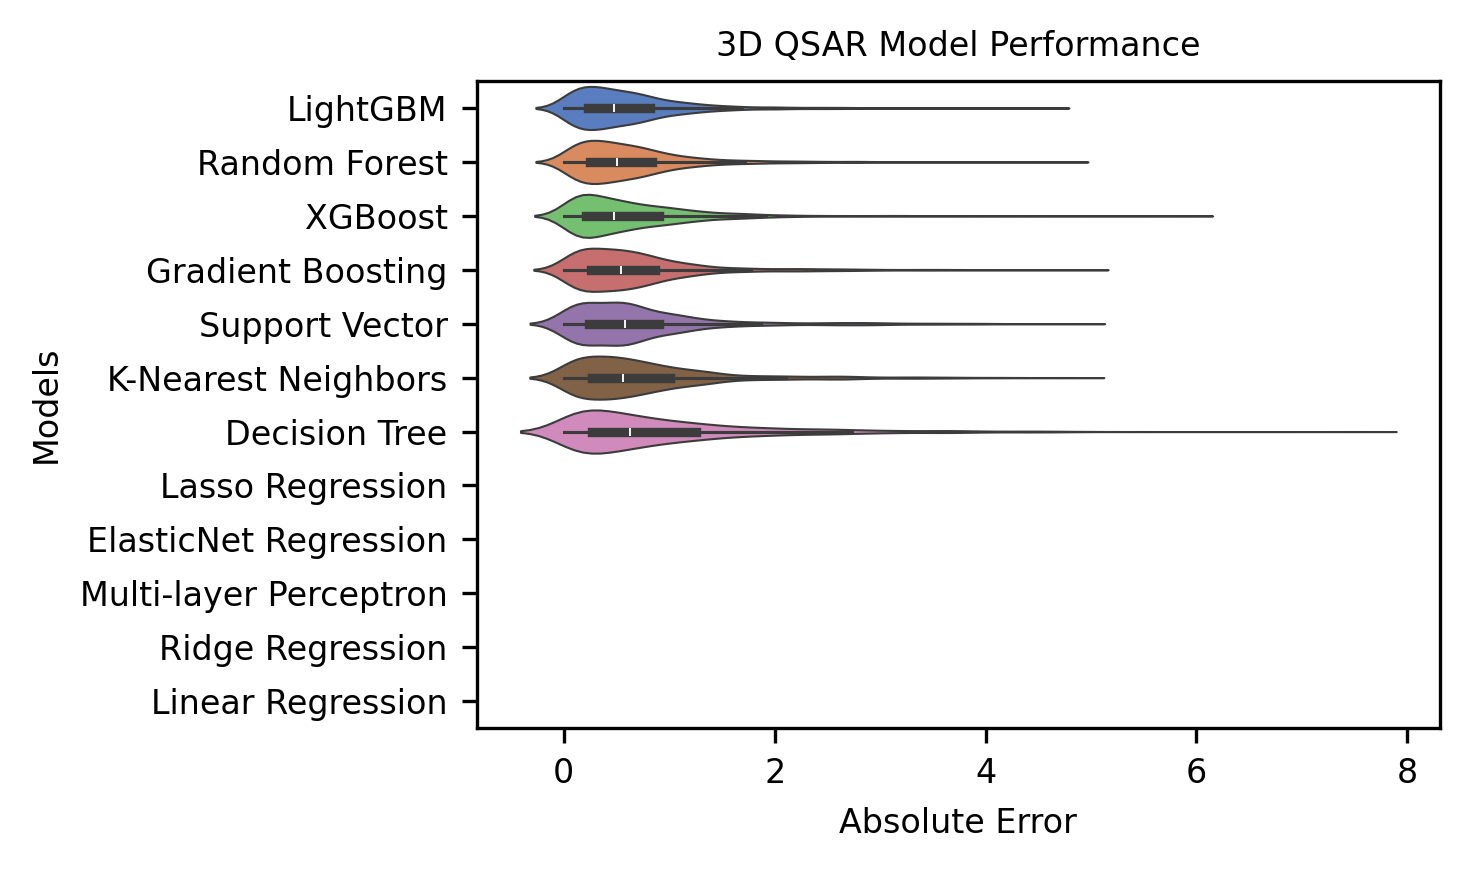

MSE scores have been saved to 3d_qasr_mse.csv


In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Assuming 'results' dictionary has been previously defined with the format:
# results[model_name] = {"MSE": mse_value, "error": list_of_errors}

# Prepare data for the plot and CSV export
residuals_data = []
mse_data = []  # List to store MSE data for CSV export
for name, result in results.items():
    simplified_name = name.replace("3D-QSAR-", "")  # Remove the prefix
    mse_data.append({"Model": simplified_name, "MSE": result["MSE"]})
    if result["MSE"] <= 10:  # Filtering out models with high MSE values
        model_residuals = pd.DataFrame({"Model": simplified_name, "Error": result["error"]})
        residuals_data.append(model_residuals)

# Create DataFrame for MSE and sort it
mse_df = pd.DataFrame(mse_data)
mse_df.sort_values(by="MSE", ascending=True, inplace=True)  # Sort by MSE

# Use the sorted order for the violin plot
model_order = mse_df["Model"].tolist()  # Get the order of models sorted by MSE

# Concatenate data from all selected models into a single DataFrame for plotting
residuals_df = pd.concat(residuals_data, ignore_index=True)
residuals_df = residuals_df[residuals_df['Model'].isin(model_order)]  # Filter only models within the MSE threshold

# Generate violin plot with academic aesthetics
plt.figure(figsize=(5, 3), dpi=300)
sns.violinplot(
    x="Error", 
    y="Model", 
    data=residuals_df, 
    order=model_order,  # Apply the sorted order to the plot
    palette="muted",
    linewidth=0.5
)
plt.title("3D QSAR Model Performance", fontsize=8)
plt.xlabel("Absolute Error", fontsize=8)
plt.ylabel("Models", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig("3d_qsar_violin_plot.png")
plt.show()

# Save the sorted MSE data to CSV
csv_path = "3d_qasr_mse.csv"
mse_df.to_csv(csv_path, index=False)
print(f"MSE scores have been saved to {csv_path}")

#### three_d true

In [ ]:
from rdkit.Chem import rdPartialCharges

def calculate_3dqsar_repr(SMILES, max_atoms=100, three_d=True):
    mol = Chem.MolFromSmiles(SMILES)  # Create a molecule object from SMILES representation
    mol = Chem.AddHs(mol)  # Add hydrogen atoms
    if three_d:
        AllChem.EmbedMolecule(mol, AllChem.ETKDG())  # Compute 3D coordinates
    else:
        AllChem.Compute2DCoords(mol)  # Compute 2D coordinates
    natoms = mol.GetNumAtoms()  # Get the number of atoms
    rdPartialCharges.ComputeGasteigerCharges(mol)  # Calculate Gasteiger charges for the molecule
    charges = np.array([float(atom.GetProp("_GasteigerCharge")) for atom in mol.GetAtoms()])  # Retrieve charge values
    coords = mol.GetConformer().GetPositions()  # Get atomic coordinates
    coulomb_matrix = np.zeros((max_atoms, max_atoms))  # Initialize Coulomb matrix
    n = min(max_atoms, natoms)
    for i in range(n):  # Iterate over atoms
        for j in range(i, n):
            if i == j:
                coulomb_matrix[i, j] = 0.5 * charges[i] ** 2
            if i != j:
                delta = np.linalg.norm(coords[i] - coords[j])  # Calculate the distance between atoms
                if delta != 0:
                    coulomb_matrix[i, j] = charges[i] * charges[j] / delta  # Compute elements of the Coulomb matrix
                    coulomb_matrix[j, i] = coulomb_matrix[i, j]
    coulomb_matrix = np.where(np.isinf(coulomb_matrix), 0, coulomb_matrix)  # Handle infinite values
    coulomb_matrix = np.where(np.isnan(coulomb_matrix), 0, coulomb_matrix)  # Handle NaN values
    return coulomb_matrix.reshape(max_atoms*max_atoms).tolist()  # Convert the Coulomb matrix to a list and return

train_data["3dqsar_mr"] = train_data["SMILES"].apply(calculate_3dqsar_repr)
test_data["3dqsar_mr"] = test_data["SMILES"].apply(calculate_3dqsar_repr)

from sklearn.decomposition import PCA

# Define a PCA object, setting n_components to 512, which means reducing dimensions to 512
pca = PCA(n_components=512)

# Fit and transform the training data
train_data_pca = pca.fit_transform(np.array(train_data["3dqsar_mr"].tolist()))

# Transform the test data
test_data_pca = pca.transform(np.array(test_data["3dqsar_mr"].tolist()))

# Store the reduced dimension data as a new column
train_data["3dqsar_mr_pca"] = train_data_pca.tolist()
test_data["3dqsar_mr_pca"] = test_data_pca.tolist()

# three_d true:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Convert training and testing data to NumPy arrays
train_x = np.array(train_data["3dqsar_mr_pca"].values.tolist())
train_y = np.array(train_data["TARGET"].values.tolist())
test_x = np.array(test_data["3dqsar_mr_pca"].values.tolist())
test_y = np.array(test_data["TARGET"].values.tolist())

# List of regressors to be used
regressors = [
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge(random_state=42)),
    ("Lasso Regression", Lasso(random_state=42)),
    ("ElasticNet Regression", ElasticNet(random_state=42)),
    ("Support Vector", SVR()),
    ("K-Nearest Neighbors", KNeighborsRegressor()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("Multi-layer Perceptron", MLPRegressor(
        hidden_layer_sizes=(128,64,32),
        learning_rate_init=0.0001,
        activation='relu', solver='adam', 
        max_iter=10000, random_state=42)),
]

# Train and predict with each regressor, compute performance metrics
results = {}
for name, regressor in regressors:
    regressor.fit(train_x, train_y)
    pred_train_y = regressor.predict(train_x)
    pred_test_y = regressor.predict(test_x)
    mse = mean_squared_error(test_y, pred_test_y)
    se = abs(test_y - pred_test_y).tolist()
    results[name] = {"MSE": mse, "error": se}
    print(f"[3D-QSAR][{name}]\tMSE:{mse:.4f}")

# Gather model names and MSE values into a DataFrame
mse_data = [{"Model": name, "MSE": result["MSE"]} for name, result in results.items()]
mse_df = pd.DataFrame(mse_data)
mse_df.sort_values(by="MSE", ascending=True, inplace=True)  # Sort by MSE for clarity

# Save the DataFrame to a CSV file
csv_path = "model_mse_scores_true.csv"
mse_df.to_csv(csv_path, index=False)
print(f"MSE scores have been saved to {csv_path}")

# Prepare residuals data for violin plot
residuals_data = []
for name, result in results.items():
    model_residuals = pd.DataFrame({"Model": name, "Error": result["error"]})
    residuals_data.append(model_residuals)

residuals_df = pd.concat(residuals_data, ignore_index=True)
model_order = residuals_df.groupby("Model")["Error"].median().sort_values().index

# Generate violin plot with academic aesthetics
plt.figure(figsize=(5, 3), dpi=300)
sns.violinplot(
    x="Error", 
    y="Model", 
    data=residuals_df, 
    order=model_order, 
    palette="muted",
    linewidth=0.5
)
plt.title("3D QSAR Model Performance", fontsize=8)
plt.xlabel("Absolute Error", fontsize=8)
plt.ylabel("Models", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig("3d_qsar_violin_plot_true.png")
plt.show()

## GNN_Representation

In [89]:
import math
import numpy
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator
from pathlib import Path

import torch
import torch.nn.functional as Fun
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU

In [90]:
from torch_geometric.datasets import QM9
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool

In [91]:
# specify the local data path
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [93]:
# load dataset
qm9 = QM9(root=DATA)
qm9[0]

Extracting /home/jhe378/works/mse803/_regression/data/raw/qm9.zip
Processing...
100%|█████████████████████████████████| 133885/133885 [01:44<00:00, 1280.98it/s]
Done!


Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])

In [97]:
qm9[0]['x']

tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [98]:
# get one regression target
y_target = pd.DataFrame(qm9.data.y.numpy())
qm9.data.y = torch.Tensor(y_target[0])

qm9 = qm9.shuffle()

# data split
data_size = 30000
train_index = int(data_size * 0.8)
test_index = train_index + int(data_size * 0.1)
val_index = test_index + int(data_size * 0.1)


# normalizing the data
data_mean = qm9.data.y[0:train_index].mean()
data_std = qm9.data.y[0:train_index].std()

qm9.data.y = (qm9.data.y - data_mean) / data_std

# datasets into DataLoader
train_loader = DataLoader(qm9[0:train_index], batch_size=64, shuffle=True)
test_loader = DataLoader(qm9[train_index:test_index], batch_size=64, shuffle=True)
val_loader = DataLoader(qm9[test_index:val_index], batch_size=64, shuffle=True)

/home/jhe378/anaconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/jhe378/anaconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryData

In [99]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network class with 3 convolutional layers and a linear layer"""

    def __init__(self, dim_h):
        """init method for GCN

        Args:
            dim_h (int): the dimension of hidden layers
        """
        super().__init__()
        self.conv1 = GCNConv(qm9.num_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = torch.nn.Linear(dim_h, 1)

    def forward(self, data):
        e = data.edge_index
        x = data.x

        x = self.conv1(x, e)
        x = x.relu()
        x = self.conv2(x, e)
        x = x.relu()
        x = self.conv3(x, e)
        x = global_mean_pool(x, data.batch)

        x = Fun.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [100]:
class GIN(torch.nn.Module):
    """Graph Isomorphism Network class with 3 GINConv layers and 2 linear layers"""

    def __init__(self, dim_h):
        """Initializing GIN class

        Args:
            dim_h (int): the dimension of hidden layers
        """
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(11, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU())
        )
        self.conv2 = GINConv(
            Sequential(
                Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU()
            )
        )
        self.conv3 = GINConv(
            Sequential(
                Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU()
            )
        )
        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch

        # Node embeddings
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        h = global_add_pool(h, batch)

        h = self.lin1(h)
        h = h.relu()
        h = Fun.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return h

In [101]:
def training(loader, model, loss, optimizer):
    """Training one epoch

    Args:
        loader (DataLoader): loader (DataLoader): training data divided into batches
        model (nn.Module): GNN model to train on
        loss (nn.functional): loss function to use during training
        optimizer (torch.optim): optimizer during training

    Returns:
        float: training loss
    """
    model.train()

    current_loss = 0
    for d in loader:
        optimizer.zero_grad()
        d.x = d.x.float()

        out = model(d)

        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        current_loss += l / len(loader)
        l.backward()
        optimizer.step()
    return current_loss, model

In [102]:
def validation(loader, model, loss):
    """Validation

    Args:
        loader (DataLoader): validation set in batches
        model (nn.Module): current trained model
        loss (nn.functional): loss function

    Returns:
        float: validation loss
    """
    model.eval()
    val_loss = 0
    for d in loader:
        out = model(d)
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        val_loss += l / len(loader)
    return val_loss

In [103]:
@torch.no_grad()
def testing(loader, model):
    """Testing

    Args:
        loader (DataLoader): test dataset
        model (nn.Module): trained model

    Returns:
        float: test loss
    """
    loss = torch.nn.MSELoss()
    test_loss = 0
    test_target = numpy.empty((0))
    test_y_target = numpy.empty((0))
    for d in loader:
        out = model(d)
        # NOTE
        # out = out.view(d.y.size())
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        test_loss += l / len(loader)

        # save prediction vs ground truth values for plotting
        test_target = numpy.concatenate((test_target, out.detach().numpy()[:, 0]))
        test_y_target = numpy.concatenate((test_y_target, d.y.detach().numpy()))

    return test_loss, test_target, test_y_target

In [104]:
def train_epochs(epochs, model, train_loader, val_loader, path):
    """Training over all epochs

    Args:
        epochs (int): number of epochs to train for
        model (nn.Module): the current model
        train_loader (DataLoader): training data in batches
        val_loader (DataLoader): validation data in batches
        path (string): path to save the best model

    Returns:
        array: returning train and validation losses over all epochs, prediction and ground truth values for training data in the last epoch
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    loss = torch.nn.MSELoss()

    train_target = numpy.empty((0))
    train_y_target = numpy.empty((0))
    train_loss = numpy.empty(epochs)
    val_loss = numpy.empty(epochs)
    best_loss = math.inf

    for epoch in range(epochs):
        epoch_loss, model = training(train_loader, model, loss, optimizer)
        v_loss = validation(val_loader, model, loss)
        if v_loss < best_loss:
            torch.save(model.state_dict(), path)
        for d in train_loader:
            out = model(d)
            if epoch == epochs - 1:
                # record truly vs predicted values for training data from last epoch
                train_target = numpy.concatenate((train_target, out.detach().numpy()[:, 0]))
                train_y_target = numpy.concatenate((train_y_target, d.y.detach().numpy()))

        train_loss[epoch] = epoch_loss.detach().numpy()
        val_loss[epoch] = v_loss.detach().numpy()

        # print current train and val loss
        if epoch % 2 == 0:
            print(
                "Epoch: "
                + str(epoch)
                + ", Train loss: "
                + str(epoch_loss.item())
                + ", Val loss: "
                + str(v_loss.item())
            )
    return train_loss, val_loss, train_target, train_y_target

In [105]:
# training GCN for 10 epochs
epochs = 10

model = GCN(dim_h=128)

# Remember to change the path if you want to keep the previously trained model
gcn_train_loss, gcn_val_loss, gcn_train_target, gcn_train_y_target = train_epochs(
    epochs, model, train_loader, test_loader, "GCN_model.pt"
)

Epoch: 0, Train loss: 0.9065729379653931, Val loss: 0.9427485466003418
Epoch: 2, Train loss: 0.8340529799461365, Val loss: 0.9148880839347839
Epoch: 4, Train loss: 0.8091458082199097, Val loss: 0.8814126253128052
Epoch: 6, Train loss: 0.7940199971199036, Val loss: 0.8404255509376526
Epoch: 8, Train loss: 0.7568850517272949, Val loss: 0.802439272403717


In [106]:
# Training GIN for 10 epochs
model = GIN(dim_h=64)

# Remember to change the path if you want to keep the previously trained model
gin_train_loss, gin_val_loss, gin_train_target, gin_train_y_target = train_epochs(
    epochs, model, train_loader, test_loader, "GIN_model.pt"
)

Epoch: 0, Train loss: 0.7394772171974182, Val loss: 0.6415450572967529
Epoch: 2, Train loss: 0.5296422839164734, Val loss: 0.4700258672237396
Epoch: 4, Train loss: 0.49533843994140625, Val loss: 0.448514848947525
Epoch: 6, Train loss: 0.47054728865623474, Val loss: 0.40975841879844666
Epoch: 8, Train loss: 0.4353739321231842, Val loss: 0.4382861256599426


In [107]:
def plot_loss(gcn_train_loss, gcn_val_loss, gin_train_loss, gin_val_loss):
    """Plot the loss for each epoch

    Args:
        epochs (int): number of epochs
        train_loss (array): training losses for each epoch
        val_loss (array): validation losses for each epoch
    """
    plt.plot(gcn_train_loss, label="Train loss (GCN)")
    plt.plot(gcn_val_loss, label="Val loss (GCN)")
    plt.plot(gin_train_loss, label="Train loss (GIN)")
    plt.plot(gin_val_loss, label="Val loss (GIN)")
    plt.legend()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("Model Loss")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [108]:
def plot_targets(pred, ground_truth):
    """Plot true vs predicted value in a scatter plot

    Args:
        pred (array): predicted values
        ground_truth (array): ground truth values
    """
    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(pred, ground_truth, s=0.5)
    plt.xlim(-2, 7)
    plt.ylim(-2, 7)
    ax.axline((1, 1), slope=1)
    plt.xlabel("Predicted Value")
    plt.ylabel("Ground truth")
    plt.title("Ground truth vs prediction")
    plt.show()

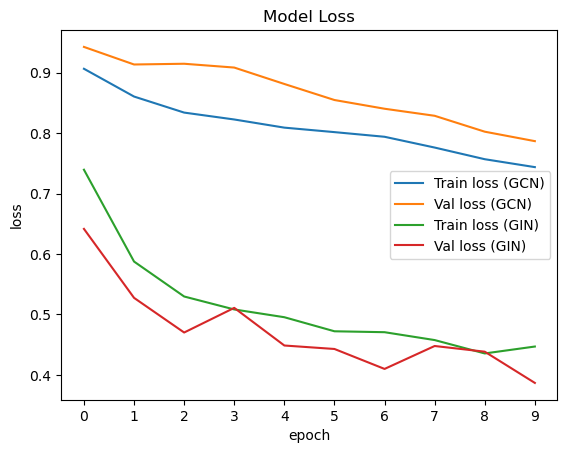

In [109]:
# Plot overall losses of GIN and GCN

plot_loss(gcn_train_loss, gcn_val_loss, gin_train_loss, gin_val_loss)

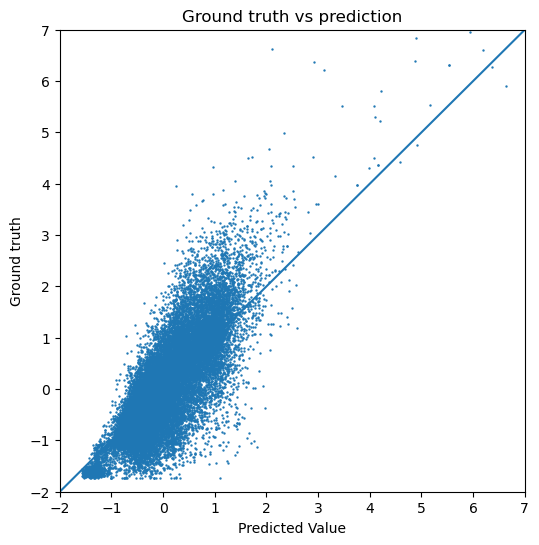

In [110]:
# Plot target and prediction for training data

plot_targets(gin_train_target, gin_train_y_target)

/tmp/ipykernel_3334925/1802362850.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("GCN_model.pt"))


Test Loss for GCN: 0.7928328514099121


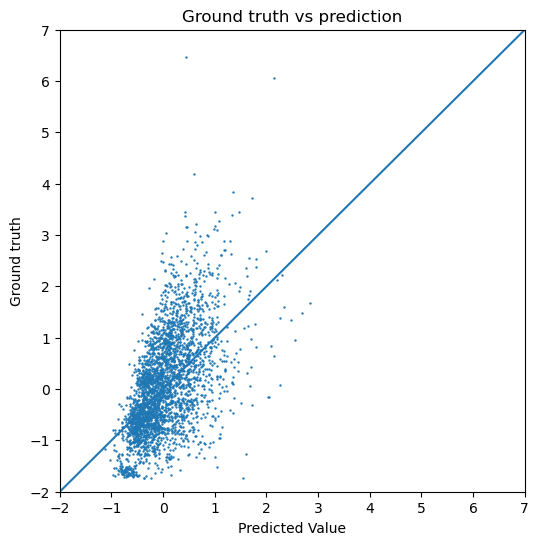

In [113]:
# Calculate test loss from the best GCN model (according to validation loss)

# load our model
model = GCN(dim_h=128)
model.load_state_dict(torch.load("GCN_model.pt"))

# calculate test loss
gcn_test_loss, gcn_test_target, gcn_test_y = testing(test_loader, model)

print("Test Loss for GCN: " + str(gcn_test_loss.item()))

# plot prediction vs ground truth
plot_targets(gcn_test_target, gcn_test_y)

/tmp/ipykernel_3334925/2373311285.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("GIN_model.pt"))


Test Loss for GIN: 0.45612427592277527


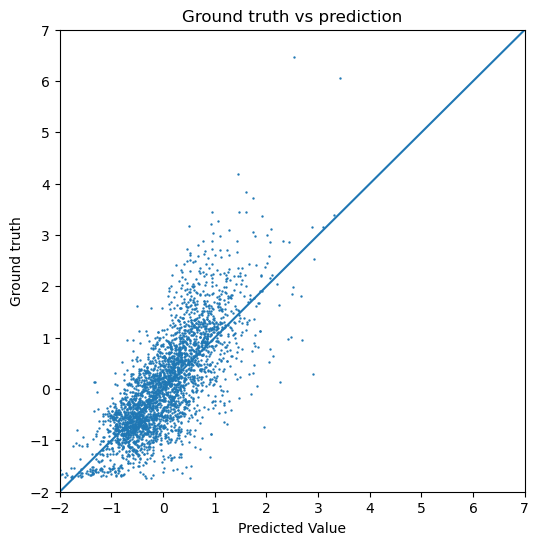

In [114]:
# Calculate test loss from the best GIN model (according to validation loss)

# load our model
model = GIN(dim_h=64)
model.load_state_dict(torch.load("GIN_model.pt"))

# calculate test loss
gin_test_loss, gin_test_target, gin_test_y = testing(test_loader, model)

print("Test Loss for GIN: " + str(gin_test_loss.item()))

# plot prediction vs ground truth
plot_targets(gin_test_target, gin_test_y)

/tmp/ipykernel_4018249/2431682919.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


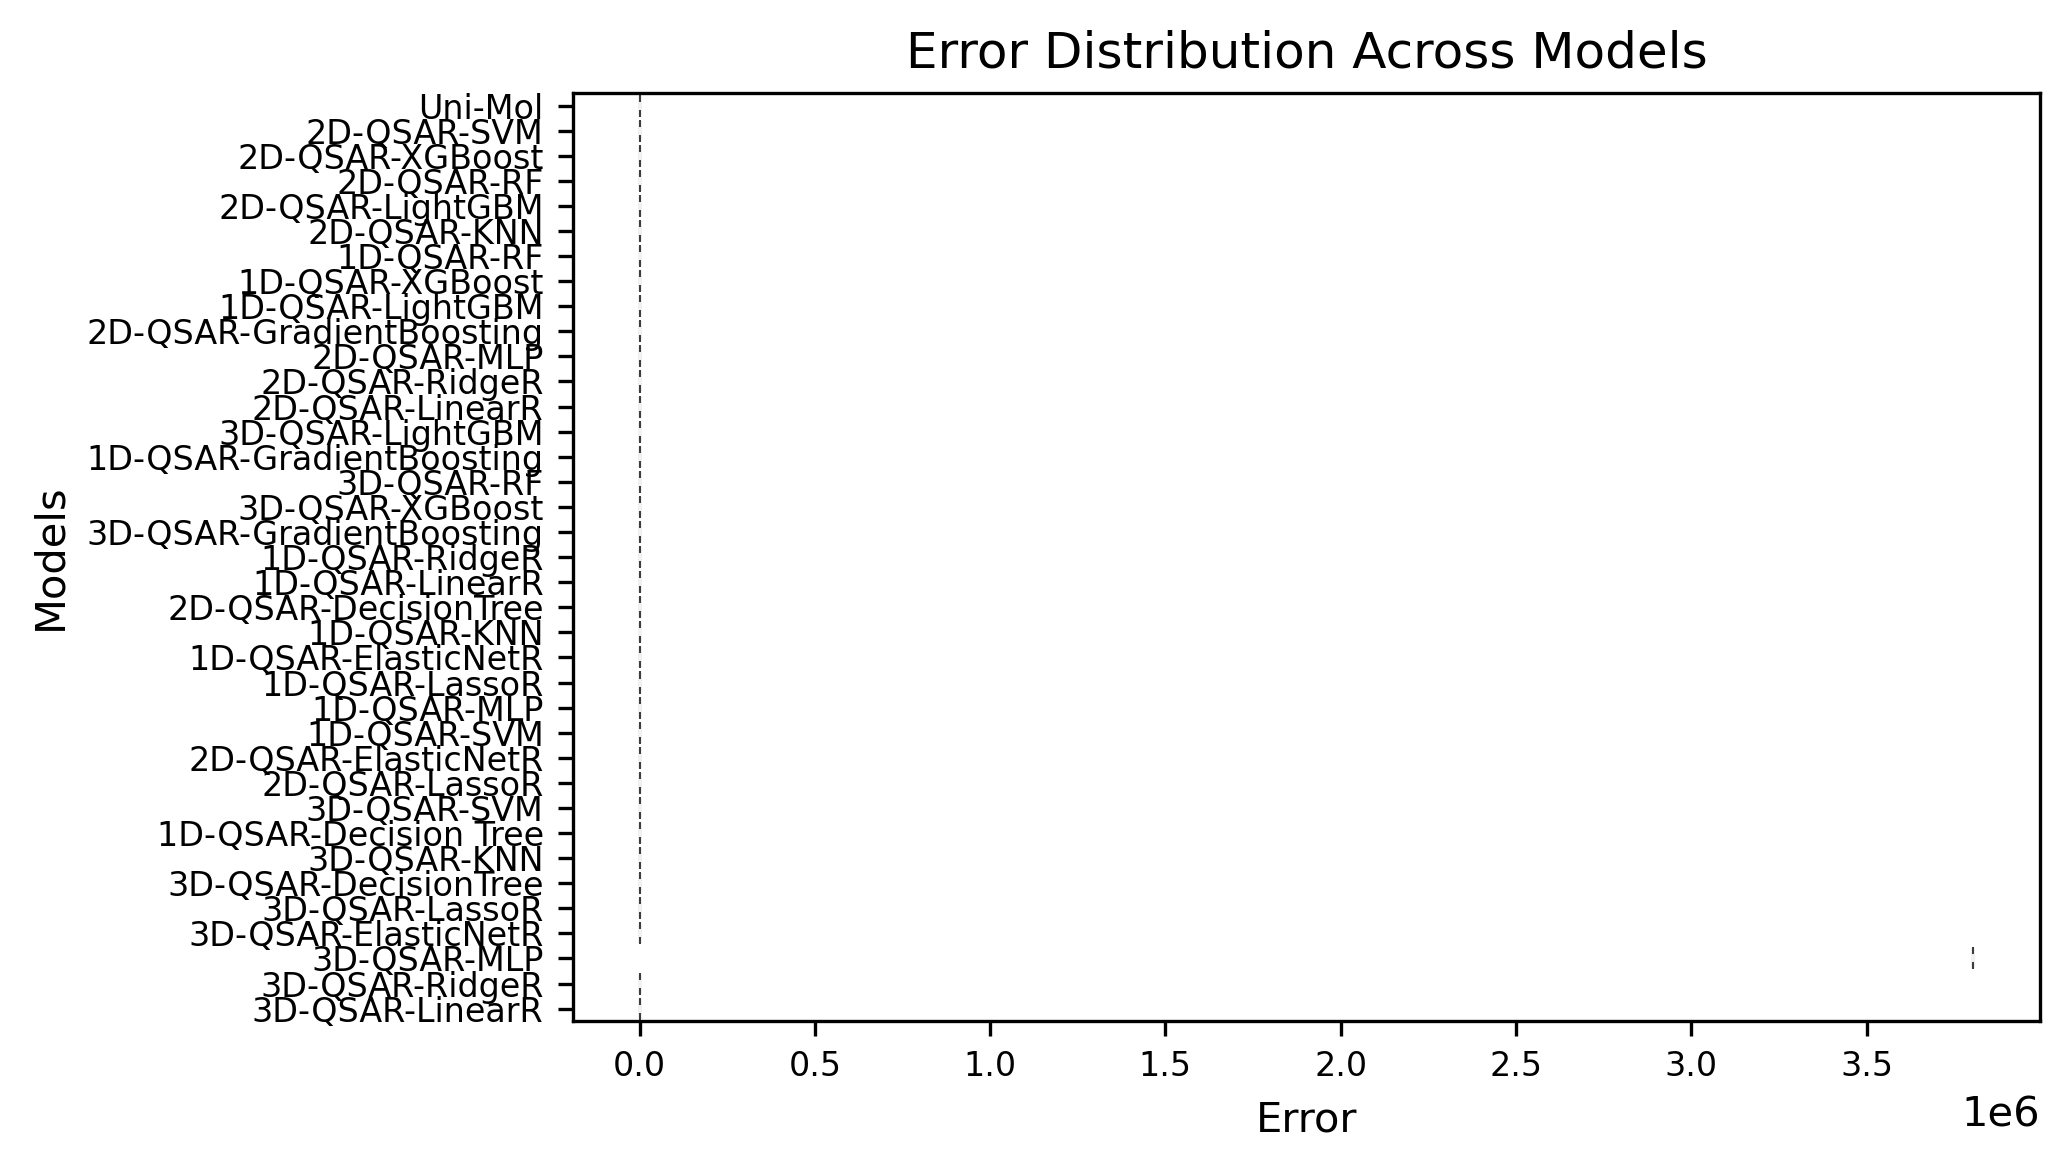

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Provided Data
data = {
    "Model": [
        "Uni-Mol", "2D-QSAR-SVM", "2D-QSAR-XGBoost", "2D-QSAR-RF", "2D-QSAR-LightGBM", 
        "2D-QSAR-KNN", "1D-QSAR-RF", "1D-QSAR-XGBoost", "1D-QSAR-LightGBM", 
        "2D-QSAR-GradientBoosting", "2D-QSAR-MLP", "2D-QSAR-RidgeR", "2D-QSAR-LinearR", 
        "3D-QSAR-LightGBM", "1D-QSAR-GradientBoosting", "3D-QSAR-RF", "3D-QSAR-XGBoost", 
        "3D-QSAR-GradientBoosting", "1D-QSAR-RidgeR", "1D-QSAR-LinearR", "2D-QSAR-DecisionTree", 
        "1D-QSAR-KNN", "1D-QSAR-ElasticNetR", "1D-QSAR-LassoR", "1D-QSAR-MLP", "1D-QSAR-SVM", 
        "2D-QSAR-ElasticNetR", "2D-QSAR-LassoR", "3D-QSAR-SVM", "1D-QSAR-Decision Tree", 
        "3D-QSAR-KNN", "3D-QSAR-DecisionTree", "3D-QSAR-LassoR", "3D-QSAR-ElasticNetR", 
        "3D-QSAR-MLP", "3D-QSAR-RidgeR", "3D-QSAR-LinearR"
    ],
    "Median Error": [
        0.419774, 0.455441, 0.459129, 0.47166, 0.479684, 0.480645, 0.605183, 0.605652, 0.642647, 
        0.669449, 0.693308, 0.715356, 0.715559, 0.730661, 0.760707, 0.783114, 0.810273, 0.866329, 
        0.885736, 0.885739, 0.889239, 0.911012, 0.926934, 0.928588, 0.938524, 0.939777, 1.010851, 
        1.010851, 1.042737, 1.057852, 1.194292, 1.598439, 805.758003, 2390.261763, 3482168556886455484416.0, 
        4392658479297741235159040.0, 34953863171341550859845632.0
    ],
    "Errors": [
        [2.522, 2.034, 2.124], [1.659, 1.802, 1.339], [1.524, 1.569, 0.739], [1.988, 2.382, 0.845], 
        [2.022, 2.592, 0.795], [1.51, 1.508, 0.975], [2.391, 2.477, 3.016], [2.51, 3.2, 2.426], 
        [2.347, 2.509, 2.554], [2.919, 2.653, 2.551], [1.12, 1.384, 1.224], [2.788, 2.147, 2.513], 
        [2.786, 2.143, 2.511], [3.854, 1.365, 1.63], [4.203, 4.083, 3.797], [3.555, 2.413, 2.851], 
        [3.826, 0.888, 1.363], [4.338, 2.899, 2.783], [4.533, 4.121, 4.016], [4.533, 4.121, 4.016], 
        [0.57, 0.18, 1.54], [2.524, 3.312, 4.324], [4.599, 4.317, 4.138], [4.597, 4.317, 4.133], 
        [4.539, 4.24, 4.049], [4.759, 4.453, 4.289], [4.57, 4.32, 4.09], [4.57, 4.32, 4.09], 
        [4.75, 4.5, 4.27], [2.524, 2.9, 2.355], [4.92, 4.12, 5.354], [3.03, 1.14, 1.659], 
        [4.569, 4.319, 4.089], [4.569, 4.319, 4.089], [3804401.305, 3804401.551, 3804401.44], 
        [4.324, 3.932, 3.681], [4.287, 3.435, 3.171]
    ]
}

# Convert data to DataFrame
df = pd.DataFrame(data)

# Prepare data for violin plot
residuals_data = []
for index, row in df.iterrows():
    residuals = pd.DataFrame({
        "Model": row["Model"],
        "Error": row["Errors"]
    })
    residuals_data.append(residuals)

residuals_df = pd.concat(residuals_data, ignore_index=True)

# Sort models by median error
model_order = df.sort_values(by="Median Error")["Model"]

# Generate violin plot
plt.figure(figsize=(7, 4), dpi=300)
sns.violinplot(
    x="Error", y="Model", data=residuals_df, order=model_order,
    palette="muted", linewidth=0.5
)
plt.title("Error Distribution Across Models", fontsize=12)
plt.xlabel("Error", fontsize=10)
plt.ylabel("Models", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig("qasr_violin_plot.png")
plt.show()
